In [1]:
import os
from PIL import Image

def is_valid_image(filename):
    try:
        img = Image.open(filename)
        img.verify()
        return True
    except:
        return False

def remove_invalid_images(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            if not is_valid_image(os.path.join(root, file)):
                os.remove(os.path.join(root, file))

remove_invalid_images('DATASET/TRAIN')
remove_invalid_images('DATASET/TEST')


In [3]:
##Data Preparation:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the training and testing data
train_data_dir = 'DATASET/TRAIN'
test_data_dir = 'DATASET/TEST'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

# Print the number of images in each category
num_classes = len(train_generator.class_indices)
print('Number of classes:', num_classes)

# Print the shape of the training and testing data
print('Shape of training data:', train_generator[0][0].shape)
print('Shape of testing data:', test_generator[0][0].shape)


Found 1074 images belonging to 5 classes.
Found 466 images belonging to 5 classes.
Number of classes: 5
Shape of training data: (32, 224, 224, 3)
Shape of testing data: (32, 224, 224, 3)


In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'DATASET/TRAIN'
TEST_DIR = 'DATASET/TEST'
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')


Found 1074 images belonging to 5 classes.
Found 466 images belonging to 5 classes.


In [6]:
##Model Building:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Add fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 148, 148, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 72, 72, 64)      

In [9]:
##Model Training and Evaluation:
from keras.callbacks import EarlyStopping, ModelCheckpoint

EPOCHS = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    epochs=EPOCHS,
                    validation_data=test_generator,
                    validation_steps=test_generator.n//test_generator.batch_size,
                    callbacks=[es, mc])


Epoch 1/50
 3/33 [=>............................] - ETA: 31s - loss: 3.5468 - accuracy: 0.1562

C:\Users\MSI\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


33/33 [==============================] - ETA: 0s - loss: 2.3596 - accuracy: 0.2917
Epoch 1: val_accuracy improved from -inf to 0.15848, saving model to best_model.h5
33/33 [==============================] - 43s 1s/step - loss: 2.3596 - accuracy: 0.2917 - val_loss: 2.7290 - val_accuracy: 0.1585
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 1.7981 - accuracy: 0.4040
Epoch 2: val_accuracy improved from 0.15848 to 0.24554, saving model to best_model.h5
33/33 [==============================] - 45s 1s/step - loss: 1.7981 - accuracy: 0.4040 - val_loss: 4.4832 - val_accuracy: 0.2455
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 1.5597 - accuracy: 0.4655
Epoch 3: val_accuracy did not improve from 0.24554
33/33 [==============================] - 48s 1s/step - loss: 1.5597 - accuracy: 0.4655 - val_loss: 6.5743 - val_accuracy: 0.2433
Epoch 4/50
33/33 [==============================] - ETA: 0s - loss: 1.5147 - accuracy: 0.4741
Epoch 4: val_accuracy improv

33/33 [==============================] - ETA: 0s - loss: 0.4850 - accuracy: 0.8205
Epoch 29: val_accuracy did not improve from 0.83482
33/33 [==============================] - 47s 1s/step - loss: 0.4850 - accuracy: 0.8205 - val_loss: 0.6844 - val_accuracy: 0.7790
Epoch 30/50
33/33 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.8292
Epoch 30: val_accuracy did not improve from 0.83482
33/33 [==============================] - 49s 1s/step - loss: 0.5025 - accuracy: 0.8292 - val_loss: 0.6612 - val_accuracy: 0.8103
Epoch 31/50
33/33 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.8378
Epoch 31: val_accuracy did not improve from 0.83482
33/33 [==============================] - 44s 1s/step - loss: 0.4491 - accuracy: 0.8378 - val_loss: 0.5477 - val_accuracy: 0.8259
Epoch 32/50
33/33 [==============================] - ETA: 0s - loss: 0.4439 - accuracy: 0.8445
Epoch 32: val_accuracy did not improve from 0.83482
33/33 [==============================

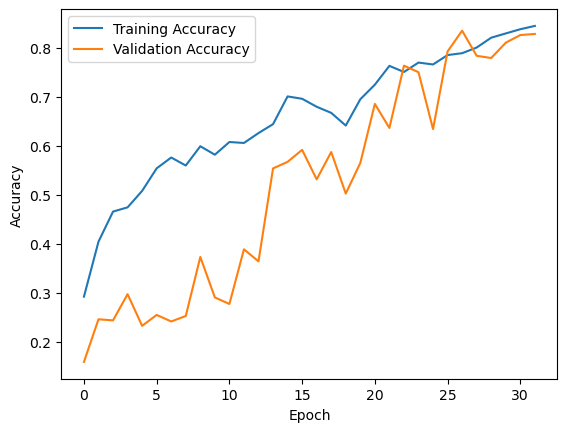

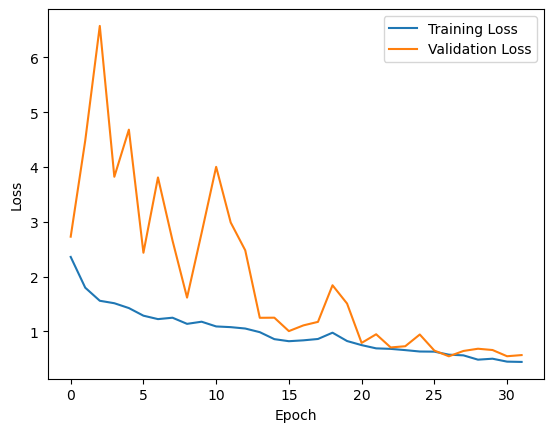

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [11]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(test_generator)


# Print the final accuracy
print("Final train accuracy: {:.2f}%, validation accuracy: {:.2f}%".format(train_acc * 100, test_acc * 100))


12/34 [=========>....................] - ETA: 11s - loss: 0.4637 - accuracy: 0.8490

C:\Users\MSI\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 [==============================] - 11s 772ms/step - loss: 0.5795 - accuracy: 0.8262
Final train accuracy: 83.71%, validation accuracy: 82.62%


In [13]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

TEST_DIR = 'DATASET/TEST'
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False)  # Set shuffle to False

# Get the predicted class probabilities for the test images
predictions = model.predict(test_generator)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_generator.classes

# Get the class labels and their corresponding indices
class_labels = list(test_generator.class_indices.keys())
class_indices = test_generator.class_indices

# Print the predicted labels and true labels for the test images
for i, image_path in enumerate(test_generator.filenames):
    image_name = os.path.basename(image_path)
    predicted_label = class_labels[predicted_labels[i]]
    true_label = class_labels[true_labels[i]]
    print("Image: {}, Predicted: {}, True: {}".format(image_name, predicted_label, true_label))


Found 466 images belonging to 5 classes.
15/15 [==============================] - 12s 765ms/step
Image: 00000000.jpg, Predicted: downdog, True: downdog
Image: 00000001.JPG, Predicted: downdog, True: downdog
Image: 00000002.jpg, Predicted: downdog, True: downdog
Image: 00000003.jpg, Predicted: downdog, True: downdog
Image: 00000004.jpg, Predicted: downdog, True: downdog
Image: 00000005.jpg, Predicted: warrior2, True: downdog
Image: 00000006.jpg, Predicted: downdog, True: downdog
Image: 00000007.jpg, Predicted: downdog, True: downdog
Image: 00000008.jpg, Predicted: downdog, True: downdog
Image: 00000009.jpg, Predicted: downdog, True: downdog
Image: 00000010.png, Predicted: downdog, True: downdog
Image: 00000011.jpg, Predicted: downdog, True: downdog
Image: 00000012.jpg, Predicted: downdog, True: downdog
Image: 00000013.jpg, Predicted: downdog, True: downdog
Image: 00000014.jpg, Predicted: downdog, True: downdog
Image: 00000016.jpg, Predicted: downdog, True: downdog
Image: 00000017.png, P